In [1]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet

生成train.txt

In [2]:
# import os
# from glob import glob

# # 根路径，根据你自己的路径修改
# root_dir = '/root/car_data_new'
# image_dir = os.path.join(root_dir, 'all_image')
# binary_dir = os.path.join(root_dir, 'binaries')
# instance_dir = os.path.join(root_dir, 'instances')
# output_txt = os.path.join(root_dir, 'train.txt')

# # 获取所有图像文件
# image_paths = sorted(glob(os.path.join(image_dir, '*.png')))

# valid_lines = []
# invalid_count = 0

# for img_path in image_paths:
#     basename = os.path.basename(img_path).replace('.png', '')

#     binary_path = os.path.join(binary_dir, f'{basename}_bin.png')
#     instance_path = os.path.join(instance_dir, f'{basename}_inst.png')

#     if os.path.exists(img_path) and os.path.exists(binary_path) and os.path.exists(instance_path):
#         valid_lines.append(f'{img_path} {binary_path} {instance_path}\n')
#     else:
#         print(f"[SKIP] Missing file for: {basename}")
#         invalid_count += 1

# # 写入 train.txt
# with open(output_txt, 'w') as f:
#     f.writelines(valid_lines)

# print(f"✅ train.txt saved to: {output_txt}")
# print(f"Total samples written: {len(valid_lines)}")
# print(f"Total skipped due to missing files: {invalid_count}")


In [3]:
# import os
# import random

# root = '/root/car_data_new'
# full_txt = os.path.join(root, 'train_all.txt')  # 这里认为 train.txt 是全量文件
# train_txt = os.path.join(root, 'train.txt')
# val_txt = os.path.join(root, 'val.txt')
# test_txt = os.path.join(root, 'test.txt')

# # 读取所有行
# with open(full_txt, 'r') as f:
#     lines = f.readlines()

# # 打乱
# random.shuffle(lines)

# # 按比例切分
# num_total = len(lines)
# num_val = int(num_total * 0.15)
# num_test = int(num_total * 0.15)
# num_train = num_total - num_val - num_test

# train_lines = lines[:num_train]
# val_lines = lines[num_train:num_train + num_val]
# test_lines = lines[num_train + num_val:]

# # 写回文件
# with open(train_txt, 'w') as f:
#     f.writelines(train_lines)
# with open(val_txt, 'w') as f:
#     f.writelines(val_lines)
# with open(test_txt, 'w') as f:
#     f.writelines(test_lines)

# print(f"✅ 划分完成！共 {num_total} 条：")
# print(f"- train: {len(train_lines)}")
# print(f"- val: {len(val_lines)}")
# print(f"- test: {len(test_lines)}")
# print(f"文件已写入：\n{train_txt}\n{val_txt}\n{test_txt}")


# define the dataset

In [4]:
# root = '/Users/smiffy/Documents/GitHub/TUSIMPLE/Data_Tusimple_PyTorch/training'
# root = r'D:\Camel\project\LaneNet-pytorch\LaneNet-PyTorch-master\Datasets\TUSimple\txt_for_local'
root = '/root/car_data_new' # 根据自己的文件路径修改
train_set = TUSIMPLE(root=root, flag='train')
valid_set = TUSIMPLE(root=root, flag='valid')
test_set = TUSIMPLE(root=root, flag='test')

print('train_set length {}'.format(len(train_set)))
print('valid_set length {}'.format(len(valid_set)))
print('test_set length {}'.format(len(test_set)))

train_set length 12480
valid_set length 2673
test_set length 2673


In [5]:
gt, bgt, igt = train_set[0]
print('image type {}'.format(type(gt)))
print('image size {} \n'.format(gt.size()))

print('gt binary image type {}'.format(type(bgt)))
print('gt binary image size {}'.format(bgt.size()))
print('items in gt binary image {} \n'.format(torch.unique(bgt)))

print('gt instance type {}'.format(type(igt)))
print('gt instance size {}'.format(igt.size()))
print('items in gt instance {} \n'.format(torch.unique(igt)))

image type <class 'torch.Tensor'>
image size torch.Size([3, 256, 512]) 

gt binary image type <class 'torch.Tensor'>
gt binary image size torch.Size([256, 512])
items in gt binary image tensor([0, 1]) 

gt instance type <class 'torch.Tensor'>
gt instance size torch.Size([256, 512])
items in gt instance tensor([0, 1, 2]) 



# DataLoader

In [6]:
batch_size = 8

In [7]:
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_valid = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=True, num_workers=0)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

# Model and optim

In [8]:
# learning_rate = 5e-4
learning_rate = 1e-4

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

LaneNet_model = Lanenet(2, 4)
LaneNet_model.to(device)

# 加载预训练权重，根据自己的文件路径进行修改
pretrained_weights = torch.load(r'/root/LaneNet-Pytorch-teach/LaneNet-PyTorch-master/TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model', map_location=device)

LaneNet_model.load_state_dict(pretrained_weights, strict=False)  # strict=False 允许部分加载

params = [p for p in LaneNet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/tmp/ipykernel_22086/2640266430.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(r'/root/LaneNet-Pytorch-teach/LaneNet-PyTorch-master/TUSI

In [ ]:
num_epochs = 40
# num_epochs = 5

In [11]:
from Lanenet.cluster_loss3 import cluster_loss
criterion = cluster_loss()
# criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([ 1.4393, 27.7296]).cuda())

In [12]:
from torch.autograd import Variable

In [13]:
loss_all = []
for epoch in range(num_epochs):
    LaneNet_model.train()
    ts = time.time()
    for iter, batch in enumerate(data_loader_train):
        input_image = batch[0].to(device)
        binary_labels = batch[1].to(device)
        instance_labels = batch[2].to(device)
        
        binary_final_logits, instance_embedding = LaneNet_model(input_image)
        # loss = LaneNet_model.compute_loss(binary_logits=binary_final_logits, binary_labels=binary_labels,
        #                               instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        binary_segmenatation_loss, instance_segmenatation_loss = criterion(binary_logits=binary_final_logits, binary_labels=binary_labels,
                                       instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        
        # binary_segmenatation_loss = criterion(binary_final_logits, binary_labels)
        loss = 1*binary_segmenatation_loss + 1*instance_segmenatation_loss
        optimizer.zero_grad()
        loss_all.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if iter % 20 == 0:
            print("epoch[{}] iter[{}] loss: [{}, {}] ".format(epoch, iter, binary_segmenatation_loss.item(), instance_segmenatation_loss.item()))
    lr_scheduler.step()
    print("Finish epoch[{}], time elapsed[{}]".format(epoch, time.time() - ts))
    torch.save(LaneNet_model.state_dict(), 
                       f"TUSIMPLE/Lanenet_output/lanenet_my_improve_{epoch}_batch_{8}.model")

epoch[0] iter[0] loss: [0.2898155450820923, 2.586794376373291] 
epoch[0] iter[20] loss: [0.14328134059906006, 1.5154448747634888] 
epoch[0] iter[40] loss: [0.10189362615346909, 1.5068167448043823] 
epoch[0] iter[60] loss: [0.10000944137573242, 1.2225239276885986] 
epoch[0] iter[80] loss: [0.10364742577075958, 1.405290126800537] 
epoch[0] iter[100] loss: [0.07227662950754166, 0.6386340856552124] 
epoch[0] iter[120] loss: [0.05441936478018761, 0.2995402216911316] 
epoch[0] iter[140] loss: [0.0805426612496376, 0.6908308267593384] 
epoch[0] iter[160] loss: [0.059871409088373184, 0.2584933638572693] 
epoch[0] iter[180] loss: [0.05753929913043976, 0.38846227526664734] 
epoch[0] iter[200] loss: [0.05283370241522789, 0.20694951713085175] 
epoch[0] iter[220] loss: [0.08315527439117432, 1.0504672527313232] 
epoch[0] iter[240] loss: [0.05940543860197067, 0.17231574654579163] 
epoch[0] iter[260] loss: [0.057399436831474304, 0.19819945096969604] 
epoch[0] iter[280] loss: [0.06495485454797745, 0.246

## Show the Loss

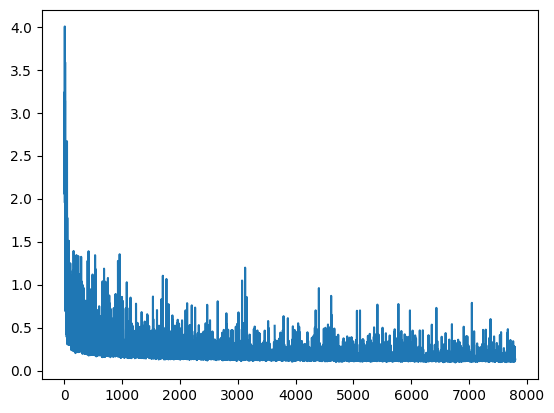

In [14]:
import matplotlib.pylab as plt
plt.plot(loss_all)

# ONNX模型转换
文件在transform.py